In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataLoad import PulsarData
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import shap

## Classification of pulsar data using the sklearn boosted decision tree method
Read in the pulsar data from the dataLoad.py script

In [69]:
features_data = PulsarData('HTRU_2').features
targets_data = PulsarData('HTRU_2').targets

Shuffle and split the data into training and test groups with 3:1 split

In [70]:
train_features_data, test_features_data, train_targets_data, test_targets_data  =  train_test_split( features_data, 
                                                        targets_data, test_size=0.25, random_state=42)

Bayesian optimisation and cross validation of hyperparameters using Simone's Troels example code.

In [71]:
def GBC_CrossValidation(n_estimators, learning_rate, max_depth, data, targets):
    """Decision Tree cross validation.
       Fits a Decision Tree with the given paramaters to the target 
       given data, calculated a CV accuracy score and returns the mean.
       The goal is to find combinations
       that maximize the accuracy
    """
    
    estimator = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, 
                                 max_depth=max_depth, random_state=0)
    
    cval = cross_val_score(estimator, data, targets, scoring='accuracy', cv=5)
    
    return cval.mean()

In [72]:
def optimize_GBC(data, targets, pars, n_iter=5):
    """Apply Bayesian Optimization to Decision Tree parameters."""
    
    def crossval_wrapper(n_estimators, learning_rate, max_depth):
        """Wrapper of Decision Tree cross validation. 
           max_depth and n_estimators
           are cast to integer before we pass them along.
        """
        return GBC_CrossValidation(n_estimators=int(n_estimators), 
                                            learning_rate=learning_rate, 
                                            max_depth=int(max_depth),
                                            data=data, 
                                            targets=targets)

    optimizer = BayesianOptimization(f=crossval_wrapper, 
                                     pbounds=pars, 
                                     random_state=42, 
                                     verbose=2)
    optimizer.maximize(init_points=4, n_iter=n_iter)

    return optimizer

In [73]:
parameters_BayesianOptimization = {"learning_rate": (0.0001, 1), 
                                   "max_depth": (1, 5),
                                   "n_estimators": (50,500)
                                  }

BayesianOptimization = optimize_GBC(train_features_data, 
                                             train_targets_data, 
                                             parameters_BayesianOptimization, 
                                             n_iter=5)
print(BayesianOptimization.max)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
|  1        |  0.9754   |  0.3746   |  4.803    |  379.4    |
|  2        |  0.98     |  0.5987   |  1.624    |  120.2    |
|  3        |  0.9788   |  0.05818  |  4.465    |  320.5    |
|  4        |  0.9794   |  0.7081   |  1.082    |  486.5    |
|  5        |  0.978    |  0.045    |  1.427    |  50.11    |
|  6        |  0.9785   |  0.2694   |  1.39     |  50.08    |
|  7        |  0.9709   |  0.697    |  3.884    |  50.08    |
|  8        |  0.9799   |  0.3956   |  1.008    |  247.2    |
|  9        |  0.9799   |  0.6653   |  1.004    |  343.3    |
{'target': 0.979959536754115, 'params': {'learning_rate': 0.5986986183486169, 'max_depth': 1.624074561769746, 'n_estimators': 120.1975341512912}}


Cross-validation on result:

In [74]:
gbc = GradientBoostingClassifier(n_estimators=int(BayesianOptimization.max['params']['n_estimators']), 
                                 learning_rate=BayesianOptimization.max['params']['learning_rate'], 
                                 max_depth=BayesianOptimization.max['params']['max_depth'], 
                                 random_state=0)
scores = cross_val_score(gbc, features_data, targets_data, cv=5, scoring='f1') 
print(f"{scores.mean():.4f} accuracy with a standard deviation of {scores.std():.4f}")

0.8757 accuracy with a standard deviation of 0.0146


Comparing with baseline (no longer needed: https://stackoverflow.com/questions/60090544/in-a-classification-problem-why-f1-score-is-more-suitable-than-accuracy-when-th)

In [75]:
#print(f"{scores.mean()-PulsarData('HTRU_2').baseline:.4f} improvement with a standard deviation of {scores.std():.4f}")

Fit a gradient boosting classifier with hyperparameters optimised by Gaussian Process Optimisation above

In [76]:
clf = GradientBoostingClassifier(n_estimators=int(BayesianOptimization.max['params']['n_estimators']), 
                                 learning_rate=BayesianOptimization.max['params']['learning_rate'], 
                                 max_depth=BayesianOptimization.max['params']['max_depth'], 
                                 random_state=0).fit(train_features_data, train_targets_data)

Compare the classified data to the test set - returns percentage match

In [77]:
clf.score(test_features_data, test_targets_data)

0.9789944134078212

SHAP-values:

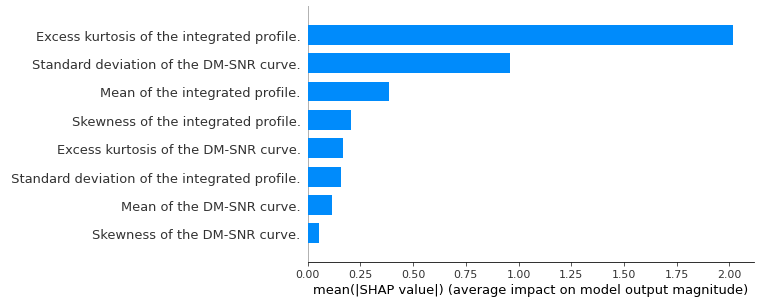

In [78]:
shap_values = shap.TreeExplainer(clf).shap_values(train_features_data)
shap.summary_plot(shap_values, train_features_data, plot_type="bar")

Feature Ranking using sklearn .feature_importances_ :   
https://as595.github.io/classification/

In [93]:
importances = clf.feature_importances_
indices = np.argsort(importances)
feature_names = features_data.columns.values
feature_names

array(['Mean of the integrated profile.',
       ' Standard deviation of the integrated profile.',
       'Excess kurtosis of the integrated profile.',
       'Skewness of the integrated profile.', 'Mean of the DM-SNR curve.',
       'Standard deviation of the DM-SNR curve.',
       'Excess kurtosis of the DM-SNR curve.',
       'Skewness of the DM-SNR curve.'], dtype=object)

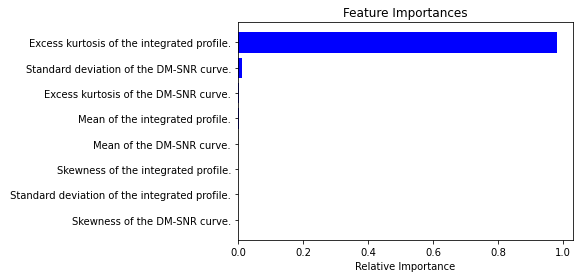

In [94]:
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), feature_names[indices])
plt.xlabel('Relative Importance')

plt.show()